# Heart Disease Prediction

Classification model based on AdaBoost ensemble technique 

In [1]:
# necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

print('Libraries imported')

Libraries imported


### Data Exploration

In [2]:
df = pd.read_csv('Dataset/heart_cleveland_upload.csv')
df.head(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0


In [3]:
df.info() # Basic info
df.describe() # Statistical summary 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        297 non-null    int64  
 1   sex        297 non-null    int64  
 2   cp         297 non-null    int64  
 3   trestbps   297 non-null    int64  
 4   chol       297 non-null    int64  
 5   fbs        297 non-null    int64  
 6   restecg    297 non-null    int64  
 7   thalach    297 non-null    int64  
 8   exang      297 non-null    int64  
 9   oldpeak    297 non-null    float64
 10  slope      297 non-null    int64  
 11  ca         297 non-null    int64  
 12  thal       297 non-null    int64  
 13  condition  297 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 32.6 KB


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,54.542088,0.676768,2.158249,131.693603,247.350168,0.144781,0.996633,149.599327,0.326599,1.055556,0.602694,0.676768,0.835017,0.461279
std,9.049736,0.468500,0.964859,17.762806,51.997583,0.352474,0.994914,22.941562,0.469761,1.166123,0.618187,0.938965,0.956690,0.499340
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,2.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,56.000000,1.000000,2.000000,130.000000,243.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,0.000000,0.000000
75%,61.000000,1.000000,3.000000,140.000000,276.000000,0.000000,2.000000,166.000000,1.000000,1.600000,1.000000,1.000000,2.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,3.000000,2.000000,1.000000


### EDA (Visualization)

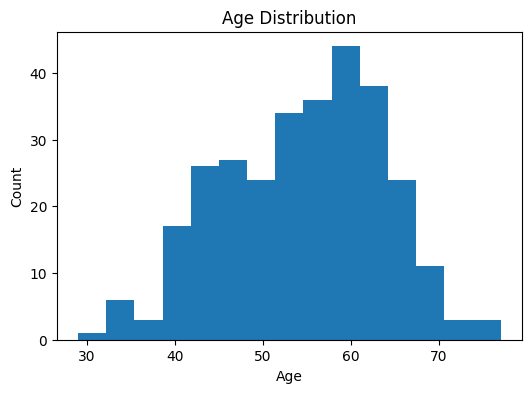

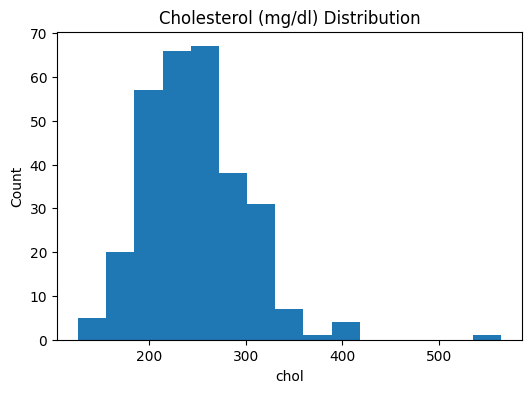

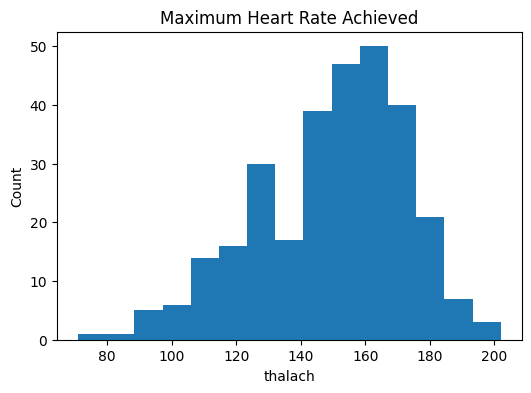

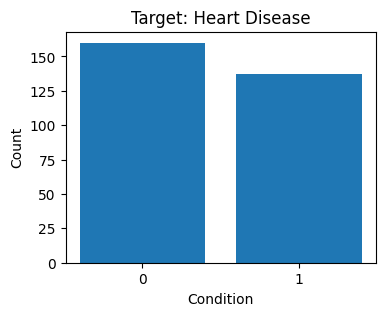

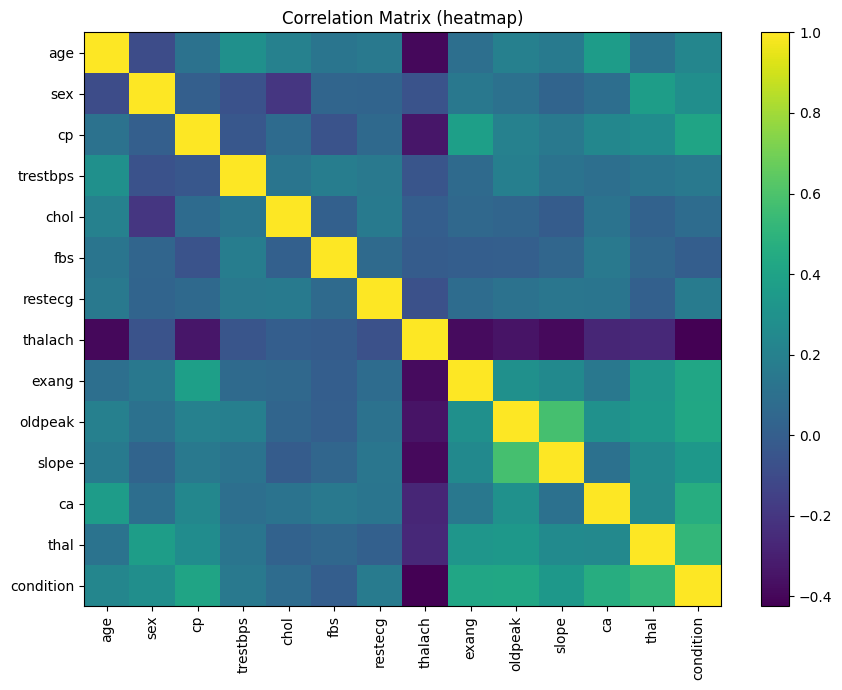


Top correlations with target:
thal       0.520516
ca         0.463189
oldpeak    0.424052
exang      0.421355
cp         0.408945
slope      0.333049
Name: condition, dtype: float64

Most negative correlations with target:
age         0.227075
restecg     0.166343
trestbps    0.153490
chol        0.080285
fbs         0.003167
thalach    -0.423817
Name: condition, dtype: float64


In [4]:
plt.figure(figsize=(6,4))
plt.hist(df['age'], bins=15)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(6,4))
plt.hist(df['chol'], bins=15)
plt.title('Cholesterol (mg/dl) Distribution')
plt.xlabel('chol')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(6,4))
plt.hist(df['thalach'], bins=15)
plt.title('Maximum Heart Rate Achieved')
plt.xlabel('thalach')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(4,3))
counts = df['condition'].value_counts().sort_index()
plt.bar(counts.index.astype(str), counts.values)
plt.title('Target: Heart Disease')
plt.xlabel('Condition')
plt.ylabel('Count')
plt.show()

corr = df.corr()
plt.figure(figsize=(9,7))
plt.imshow(corr, aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title('Correlation Matrix (heatmap)')
plt.tight_layout()
plt.show()

corr_target = corr['condition'].drop('condition').sort_values(ascending=False)
print('\nTop correlations with target:')
print(corr_target.head(6))
print('\nMost negative correlations with target:')
print(corr_target.tail(6))

### Data Preprocesssing

One-Hot Encoding for categorical vars,
Standard Scaling for numeric features.

In [6]:
X = df.drop('condition', axis=1)
y = df['condition']

categorical_cols = ['sex','cp','fbs','restecg','exang','slope','ca','thal']
numeric_cols = ['age','trestbps','chol','thalach','oldpeak']

categorical_cols = [c for c in categorical_cols if c in X.columns]
numeric_cols = [c for c in numeric_cols if c in X.columns]

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
        ('scaler', StandardScaler(), numeric_cols)
    ]
)

print('Configured preprocessor')

Configured preprocessor


Training, Testing dataset split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print('Train data:', X_train.shape, 'Test: data', X_test.shape)

Train data: (237, 13) Test: data (60, 13)


### Pipeline of model with AdaBoost 

In [8]:
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', AdaBoostClassifier(random_state=42))
])
model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('onehot', ...), ('scaler', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Building the AdaBoost Model

In [9]:
base_est = DecisionTreeClassifier(max_depth=1, random_state=42)
clf = AdaBoostClassifier(estimator=base_est, random_state=42)
pipe = Pipeline([('preprocessor', preprocessor), ('classifier', clf)])

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
print('Base AdaBoost accuracy:', accuracy_score(y_test, y_pred))
print('\nClassification report:\n', classification_report(y_test, y_pred))
print('\nConfusion matrix:\n', confusion_matrix(y_test, y_pred))

comp = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred}).reset_index(drop=True)
print('\nFirst 5 predictions vs actual:')
comp.head(5)

Base AdaBoost accuracy: 0.8666666666666667

Classification report:
               precision    recall  f1-score   support

           0       0.82      0.97      0.89        32
           1       0.95      0.75      0.84        28

    accuracy                           0.87        60
   macro avg       0.89      0.86      0.86        60
weighted avg       0.88      0.87      0.86        60


Confusion matrix:
 [[31  1]
 [ 7 21]]

First 5 predictions vs actual:


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


### Hyperparameter tuning (GridSearchCV - T2)

Search grid over n_estimators, learning_rate and estimaror_max_depth with Stratified 5-fold CV

In [10]:
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.5, 1.0],
    'classifier__estimator__max_depth': [1, 2]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(pipe, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print('Best CV score: {:.4f}'.format(grid.best_score_))
print('Best params:', grid.best_params_)

best = grid.best_estimator_
y_pred_best = best.predict(X_test)
print('Test accuracy (best): {:.4f}'.format(accuracy_score(y_test, y_pred_best)))
print('\nClassification report (best):\n', classification_report(y_test, y_pred_best))
print('\nConfusion matrix (best):\n', confusion_matrix(y_test, y_pred_best))

comp_best = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred_best}).reset_index(drop=True)
print('\nFirst 5 predictions vs actual (best):')
comp_best.head(5)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best CV score: 0.7893
Best params: {'classifier__estimator__max_depth': 1, 'classifier__learning_rate': 0.5, 'classifier__n_estimators': 50}
Test accuracy (best): 0.8667

Classification report (best):
               precision    recall  f1-score   support

           0       0.82      0.97      0.89        32
           1       0.95      0.75      0.84        28

    accuracy                           0.87        60
   macro avg       0.89      0.86      0.86        60
weighted avg       0.88      0.87      0.86        60


Confusion matrix (best):
 [[31  1]
 [ 7 21]]

First 5 predictions vs actual (best):


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [11]:
# Feature importances from best estimator
pre = best.named_steps['preprocessor']
clf_best = best.named_steps['classifier']

onehot = pre.named_transformers_['onehot']
if hasattr(onehot, 'get_feature_names_out'):
    onehot_names = list(onehot.get_feature_names_out(pre.transformers_[0][2]))
else:
    onehot_names = []

feature_names = onehot_names + numeric_cols
importances = clf_best.feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
feat_imp.head(10)


oldpeak     0.183123
thalach     0.170042
cp_3        0.111735
ca_0        0.109740
trestbps    0.074799
chol        0.073974
thal_0      0.072562
age         0.060383
exang_0     0.033818
sex_1       0.023687
dtype: float64

In [ ]:
# ROC AUC (best estimator)
try:
    y_proba = best.predict_proba(X_test)[:,1]
    print('ROC AUC:', roc_auc_score(y_test, y_proba))
except Exception as e:
    print('ROC AUC not available:', e)

ROC AUC not available: y should be a 1d array, got an array of shape (60, 2) instead.


In [ ]:
# Save the best model
import joblib

joblib.dump(best, 'heart_disease_model.pkl')
print("Heart disease model saved successfully!")

### Prediction

In [17]:
# Predictions
y_pred_final = best.predict(X_test)

# Show first 10 predictions
print("First 10 Predictions vs Actual Values:")
print("="*50)
comparison_final = pd.DataFrame({
    'Actual': y_test.values, 
    'Predicted': y_pred_final
})
print(comparison_final.to_string(index=True))
print("\n0 = No Heart Disease, 1 = Heart Disease Present")


First 10 Predictions vs Actual Values:
    Actual  Predicted
0        0          0
1        0          0
2        0          0
3        0          0
4        0          0
5        0          0
6        1          1
7        0          1
8        1          0
9        0          0
10       1          1
11       0          0
12       0          0
13       1          1
14       1          1
15       1          0
16       1          0
17       0          0
18       1          1
19       1          1
20       0          0
21       0          0
22       1          0
23       0          0
24       1          1
25       0          0
26       0          0
27       1          1
28       0          0
29       1          1
30       0          0
31       1          1
32       1          1
33       0          0
34       0          0
35       1          1
36       0          0
37       1          1
38       0          0
39       1          1
40       0          0
41       1          1
42       1     